# Data Visualization

In [1]:
import os
task_dir = 'C:\\Users\\jchen\\Desktop\\Datasets\\Heart_Isensee\\'
input_dir = task_dir + 'imagesTr\\'
labels_dir = task_dir + 'labelsTr\\'
data_dirs = [input_dir, labels_dir]
list_IDs = os.listdir(input_dir)


Shape:  (119, 231, 319)


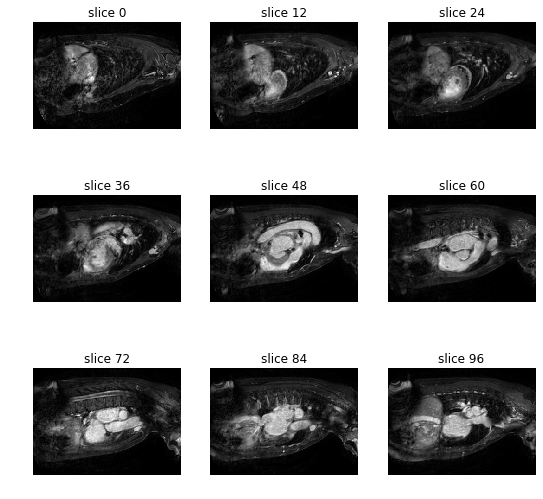

In [22]:
from keras_med_io.visualization import plotting
import nibabel as nib
import numpy as np

arr = np.load(os.path.join(task_dir, input_dir, list_IDs[1]))
print("Shape: ", arr.shape)
every_ = 12
plotting.plot_scan(arr.squeeze(), 0, every_)

In [34]:
arr_list = []
for p_id in list_IDs:
    arr = np.load(os.path.join(task_dir, input_dir, p_id))
    arr_shape = np.asarray(arr.shape)
    print("Shape appended: ", arr_shape)
    arr_list.append(arr_shape)
stacked_shapes = np.stack(arr_list)
mean_shape = np.mean(stacked_shapes, axis = 0)
max_shape = np.max(stacked_shapes, axis = 0)
print("Mean Shape: ", mean_shape, "\nMax Shape: ", max_shape)

Shape appended:  [141 231 319]
Shape appended:  [119 231 319]
Shape appended:  [130 231 319]
Shape appended:  [141 243 319]
Shape appended:  [108 231 314]
Shape appended:  [130 231 319]
Shape appended:  [130 231 319]
Shape appended:  [130 255 319]
Shape appended:  [ 97 195 315]
Shape appended:  [130 231 319]
Shape appended:  [132 231 319]
Shape appended:  [108 223 319]
Shape appended:  [119 199 319]
Shape appended:  [108 227 319]
Shape appended:  [119 243 319]
Shape appended:  [119 231 319]
Shape appended:  [130 231 319]
Shape appended:  [130 231 319]
Shape appended:  [118 231 319]
Shape appended:  [119 223 319]
Mean Shape:  [ 122.9   229.    318.55] 
Max Shape:  [141 255 319]


# Testing Actual Generators

In [18]:
from batchgenerators.transforms.color_transforms import ContrastAugmentationTransform
from batchgenerators.transforms.spatial_transforms import MirrorTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.abstract_transforms import Compose
from keras_med_io.utils.transforms_utils import compute_pad_value

def get_transforms(patch_shape = (80, 192, 128), pad_value = 0, other_transforms = None, random_crop = False):
    """
    Initializes the transforms for training.
    Args:
        patch_shape:
        pad_value:
        other_transforms: List of transforms that you would like to add (optional). Defaults to None.
        random_crop (boolean): whether or not you want to random crop or center crop. Currently, the Transformed3DGenerator
        only supports random cropping. Transformed2DGenerator supports both random_crop = True and False.
    """
    ndim = len(patch_shape)
    # brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
    spatial_transform = SpatialTransform(patch_shape,
                     do_elastic_deform = True, alpha = (0., 1500.), sigma = (30., 50.),
                     do_rotation = True, angle_z=(0, 2 * np.pi),
                     do_scale = True, scale = (0.8, 2.),
                     border_mode_data = 'constant', border_cval_data = border_cval,
                     order_data = 1, random_crop=random_crop)
    if ndim == 2:
        axes = (0, 1)
    elif ndim == 3:
        axes = (0, 1, 2)
    mirror_transform = MirrorTransform(axes = axes)
    transforms_list = [spatial_transform, mirror_transform]
    if other_transforms is not None:
        transforms_list = transforms_list + other_transforms
    composed = Compose(transforms_list)
    return composed


Directly from `examples/generators/transforms_gens.py`

In [9]:
import numpy as np
from keras_med_io.utils.custom_augmentations import get_positive_idx, get_random_slice_idx
from keras_med_io.utils.misc_utils import sanity_checks, add_channel, \
                                       get_multi_class_labels, load_data
from keras_med_io.utils.shape_io import reshape
from keras_med_io.base_generators.base_gens import BaseTransformGenerator
import nibabel as nib
import os

class Transformed3DGenerator(BaseTransformGenerator):
    """
    Loads data and applies data augmentation with `batchgenerators.transforms`.
    * Supports channels_last
    * Loads data WITH nibabel instead of SimpleITK
        * .nii files should not have the batch_size dimension

    Attributes:
        list_IDs: list of filenames
        data_dirs: list of paths to both the input dir and labels dir
        batch_size: The number of images you want in a single batch
        n_channels: number of channels
        n_classes: number of unique labels excluding the background class (i.e. binary; n_classes = 1)
        transform (Transform instance): If you want to use multiple Transforms, use the Compose Transform.
        max_patient_shape: a tuple representing the maximum patient shape in a dataset; i.e. (x,y, (z,))
        steps_per_epoch: steps per epoch during training (number of samples per epoch = steps_per_epoch * batch_size )
        shuffle: boolean
    """
    def __init__(self, list_IDs, data_dirs, batch_size, n_channels, n_classes,
                transform = None, max_patient_shape = None, steps_per_epoch = 1000, shuffle = True):

        BaseTransformGenerator.__init__(self, list_IDs = list_IDs, data_dirs = data_dirs, batch_size = batch_size,
                               n_channels = n_channels, n_classes = n_classes, ndim = 3,
                               transform = transform, max_patient_shape = max_patient_shape, steps_per_epoch = steps_per_epoch,
                               shuffle = shuffle)

    def data_gen(self, list_IDs_temp):
        """
        Generates a batch of data.
        Args:
            list_IDs_temp: batched list IDs; usually done by __getitem__
            pos_sample: boolean on if you want to sample a positive image or not
        Returns:
            tuple of two numpy arrays: x, y
        """
        images_x = []
        images_y = []
        for id in list_IDs_temp:
            # loads data as a numpy arr and then changes the type to float32
            x_train = load_data(os.path.join(self.data_dirs[0], id))
            y_train = load_data(os.path.join(self.data_dirs[1], id))
            if not x_train.shape[-1] == self.n_channels:
                # Adds channel in case there is no channel dimension
                x_train = add_channel(x_train)
                assert len(x_train.shape) == self.ndim + 1, "Input shape must be the \
                                                            shape (x,y, n_channels) or (x, y, z, n_channels)"
            if not y_train.shape[-1] == self.n_channels:
                # Adds channel in case there is no channel dimension
                y_train = add_channel(y_train)
                assert len(y_train.shape) == self.ndim + 1, "Input labels must be the \
                                                            shape (x,y, n_channels) or (x, y, z, n_channels)"
            if self.n_classes > 1: # no point to run this when binary (foreground/background)
                y_train = get_multi_class_labels(y_train, n_labels = self.n_classes, remove_background = True)
            # Padding to the max patient shape (so the arrays can be stacked)
            x_train = reshape(x_train, x_train.min(), self.max_patient_shape + (self.n_channels, ))
            y_train = reshape(y_train, 0, self.max_patient_shape + (self.n_classes, ))

                # x_train.resize(max_patient_shape + (self.n_channels, )), y_train.resize(max_patient_shape + (self.n_classes, ))
            assert sanity_checks(x_train, y_train)
            images_x.append(x_train), images_y.append(y_train)

        input_data, seg_masks = np.stack(images_x), np.stack(images_y)
        return (input_data, seg_masks)


class Transformed2DGenerator(BaseTransformGenerator):
    """
    Loads data, slices them based on the number of positive slice indices and applies data augmentation with `batchgenerators.transforms`.
    * Supports channels_last
    * .nii files should not have the batch_size dimension

    Attributes:
        list_IDs: list of filenames
        data_dirs: list of paths to both the input dir and labels dir
        batch_size: The number of images you want in a single batch
        n_channels: number of channels
        n_classes: number of unique labels excluding the background class (i.e. binary; n_classes = 1)
        n_pos: The number of positive class 2D images to include in a batch
        transform (Transform instance): If you want to use multiple Transforms, use the Compose Transform.
        max_patient_shape: a tuple representing the maximum patient shape in a dataset; i.e. ((z,)x,y)
            * Note: If you have 3D medical images and want 2D slices and don't want to overpad the slice dimension (z),
            provide a shape that is only 2D (x,y).
        step_per_epoch:
        pos_mask: boolean representing whether or not output the positive masks (X*Y)
            * If True, inputs are for capsule networks with a decoder.
            * If False, inputs are for everything else.
        shuffle: boolean
    """
    def __init__(self, list_IDs, data_dirs, batch_size, n_channels, n_classes,
                n_pos, transform = None, max_patient_shape = None, steps_per_epoch = 1000, pos_mask = True,
                shuffle = True):

        BaseTransformGenerator.__init__(self, list_IDs = list_IDs, data_dirs = data_dirs, batch_size = batch_size,
                               n_channels = n_channels, n_classes = n_classes, ndim = 2,
                               transform = transform, max_patient_shape = max_patient_shape,
                               steps_per_epoch = steps_per_epoch, shuffle = shuffle)
        self.n_pos = n_pos
        self.pos_mask = pos_mask
        if n_pos == 0:
            print("WARNING! Your data is going to be randomly sliced.")
            self.mode = "rand"
        elif n_pos == batch_size:
            print("WARNING! Your entire batch is going to be positively sampled.")
            self.mode = "pos"
        else:
            self.mode = "bal"

        if len(self.max_patient_shape) == 2:
            self.dynamic_padding_z = True # no need to pad the slice dimension

    def __getitem__(self, idx):
        """
        Defines the fetching and on-the-fly preprocessing of data.
        Args:
            idx: the id assigned to each worker
        Returns:
        if self.pos_mask is True:
            (X,Y): a batch of transformed data/labels based on the n_pos attribute.
        elif self.pos_mask is False:
            ([X, Y], [Y, pos_mask]): multi-inputs for the capsule network decoder
        """
        # file names
        max_n_idx = (idx + 1) * self.batch_size
        if max_n_idx > self.indexes.size:
            print("Adjusting for idx: ", idx)
            self.adjust_indexes(max_n_idx)

        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        # Fetches batched IDs for a thread
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # balanced sampling
        if self.mode == "bal":
            # generating data for both positive and randomly sampled data
            X_pos, Y_pos = self.data_gen(list_IDs_temp[:self.n_pos], pos_sample = True)
            X_rand, Y_rand = self.data_gen(list_IDs_temp[self.n_pos:], pos_sample = False)
            # concatenating all the corresponding data
            X, Y = np.concatenate([X_pos, X_rand], axis = 0), np.concatenate([Y_pos, Y_rand], axis = 0)
            # shuffling the order of the positive/random patches
            out_rand_indices = np.arange(0, X.shape[0])
            np.random.shuffle(out_rand_indices)
            X, Y = X[out_rand_indices], Y[out_rand_indices]
        # random sampling
        elif self.mode == "rand":
            X, Y = self.data_gen(list_IDs_temp, pos_sample = False)
        elif self.mode == "pos":
            X, Y = self.data_gen(list_IDs_temp, pos_sample = True)
        # data augmentation
        if self.transform is not None:
            X, Y = self.apply_transform(X, Y)
        # print("Getting item of size: ", indexes.size, "out of ", self.indexes.size, "with idx: ", idx, "\nX shape: ", X.shape)
        assert X.shape[0] == self.batch_size, "The outputted batch doesn't match the batch size."
        if self.pos_mask:
            pos_mask = X * Y
            return ([X, Y], [Y, pos_mask])
        elif not self.pos_mask:
            return (X, Y)

    def data_gen(self, list_IDs_temp, pos_sample):
        """
        Generates a batch of data.
        Args:
            list_IDs_temp: batched list IDs; usually done by __getitem__
            pos_sample: boolean on if you want to sample a positive image or not
        Returns:
            tuple of two numpy arrays: x, y
        """
        images_x = []
        images_y = []
        for id in list_IDs_temp:
            # loads data as a numpy arr and then changes the type to float32
            x_train = load_data(os.path.join(self.data_dirs[0], id))
            y_train = load_data(os.path.join(self.data_dirs[1], id))
            if not x_train.shape[-1] == self.n_channels:
                # Adds channel in case there is no channel dimension
                x_train = add_channel(x_train)
            if not y_train.shape[-1] == self.n_channels:
                # Adds channel in case there is no channel dimension
                y_train = add_channel(y_train)

            if self.n_classes > 1: # no point to run this when binary (foreground/background)
                y_train = get_multi_class_labels(y_train, n_labels = self.n_classes, remove_background = True)

            # Padding to the max patient shape (so the arrays can be stacked)
            if self.dynamic_padding_z: # for when you don't want to pad the slice dimension (bc that usually changes in images)
                pad_shape = (x_train.shape[0], ) + self.max_patient_shape
            elif not self.dynamic_padding_z:
                pad_shape = self.max_patient_shape
            x_train = reshape(x_train, x_train.min(), pad_shape + (self.n_channels, ))
            y_train = reshape(y_train, 0, pad_shape + (self.n_classes, ))
            assert sanity_checks(x_train, y_train)
            # extracting slice:
            if pos_sample:
                slice_idx = get_positive_idx(y_train)[0]
            elif not pos_sample:
                slice_idx = get_random_slice_idx(x_train)

            images_x.append(x_train[slice_idx]), images_y.append(y_train[slice_idx])

        input_data, seg_masks = np.stack(images_x), np.stack(images_y)
        return (input_data, seg_masks)


## 3D Data Generation

In [19]:
patch_shape = (80, 192, 128)
# brightness_transform = ContrastAugmentationTransform((0.3, 3.), preserve_range=True)
border_cval = compute_pad_value(input_dir, list_IDs)
composed = get_transforms(patch_shape, pad_value = border_cval, random_crop = True)

Computing min/pad value...


In [20]:
# purposely excluding max_patient_shape; it's automatically found
steps_per_epoch = 1000
batch_size = 2
gen = Transformed3DGenerator(list_IDs, data_dirs, batch_size = batch_size, n_channels = 1, n_classes = 1, \
                             transform = composed, steps_per_epoch = steps_per_epoch)

Computing shape statistics...
Max Patient Shape:  (141, 255, 319) 
Mean Patient Shape:  (122.90000000000001, 229.0, 318.55000000000001) 
Min Patient Shape:  (97, 195, 314)
Adjusting the indexes since the total number of required samples (steps_per_epoch * batch_size) is greater than the number of provided images.
Done!


In [21]:
x, y = gen.__getitem__(1)
assert len(gen) == steps_per_epoch
print("Steps per epoch: ", len(gen), "\nInput shape: ", x.shape, "\nLabel Shape: ", y.shape)

Steps per epoch:  1000 
Input shape:  (2, 80, 192, 128, 1) 
Label Shape:  (2, 80, 192, 128, 1)


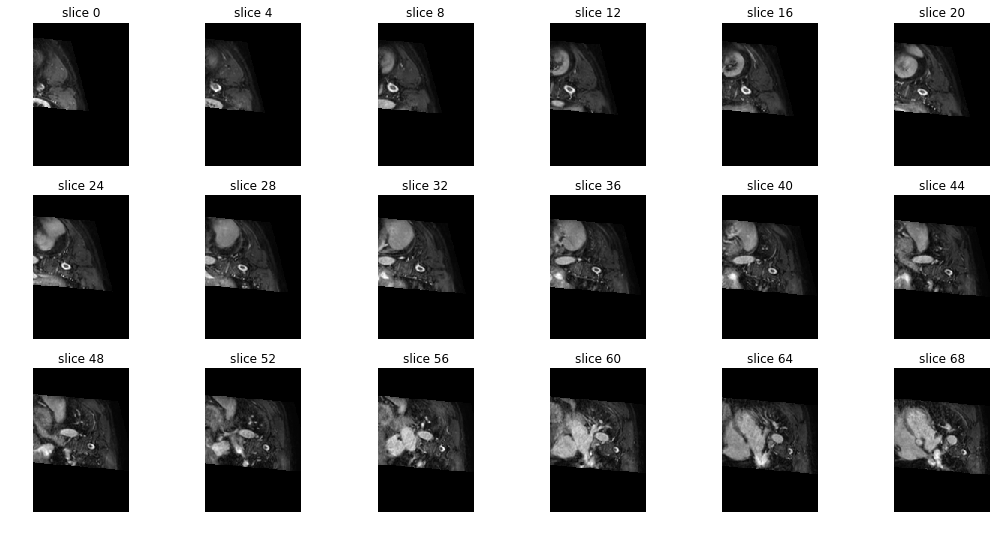

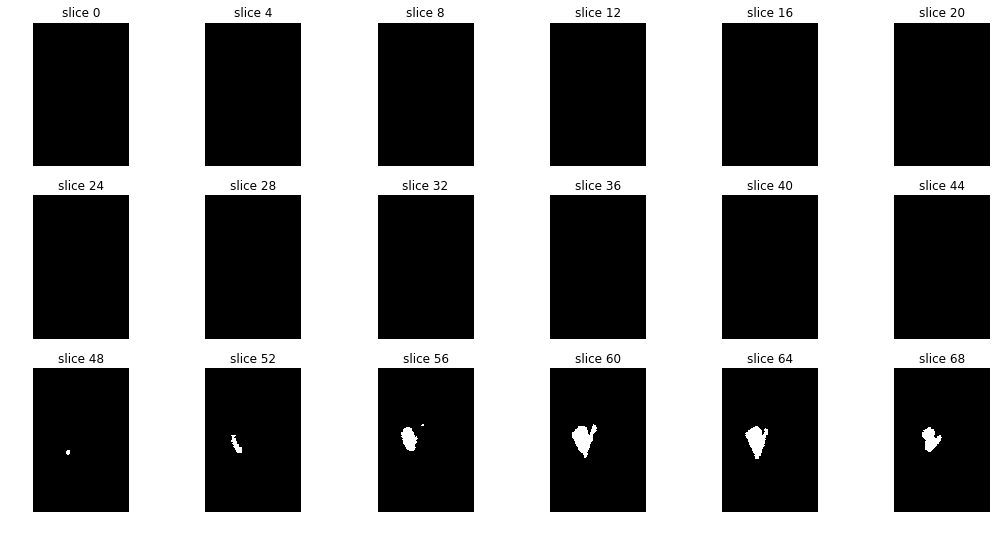

In [27]:
batch_ = 1
every_ = 4
plotting.plot_scan(x[batch_].squeeze(), 0, every_, cols = 6)
plotting.plot_scan(y[batch_].squeeze(), 0, every_, cols = 6)

## 2D Data Generation

In [29]:
batch_size = 33
patch_shape = (256, 320)
border_cval = compute_pad_value(input_dir, list_IDs)
composed = get_transforms(patch_shape, pad_value = border_cval, random_crop = False)

Computing min/pad value...


In [31]:
# purposely excluding max_patient_shape; it's automatically found
batch_size = 33
n_pos = round(batch_size // 3)
steps_per_epoch = 1000
print("Number of positive slices: ", n_pos)
gen = Transformed2DGenerator(list_IDs, data_dirs, batch_size = batch_size, n_channels = 1, n_classes = 1, n_pos = n_pos,\
                             transform = composed, max_patient_shape = (256, 320), steps_per_epoch = steps_per_epoch, pos_mask = False)

Number of positive slices:  11
Adjusting the indexes since the total number of required samples (steps_per_epoch * batch_size) is greater than the number of provided images.
Done!


In [32]:
x, y = gen.__getitem__(1)
assert len(gen) == steps_per_epoch
print("Steps per epoch: ", len(gen), "\nInput shape: ", x.shape, "\nLabel Shape: ", y.shape)

Steps per epoch:  1000 
Input shape:  (33, 256, 320, 1) 
Label Shape:  (33, 256, 320, 1)


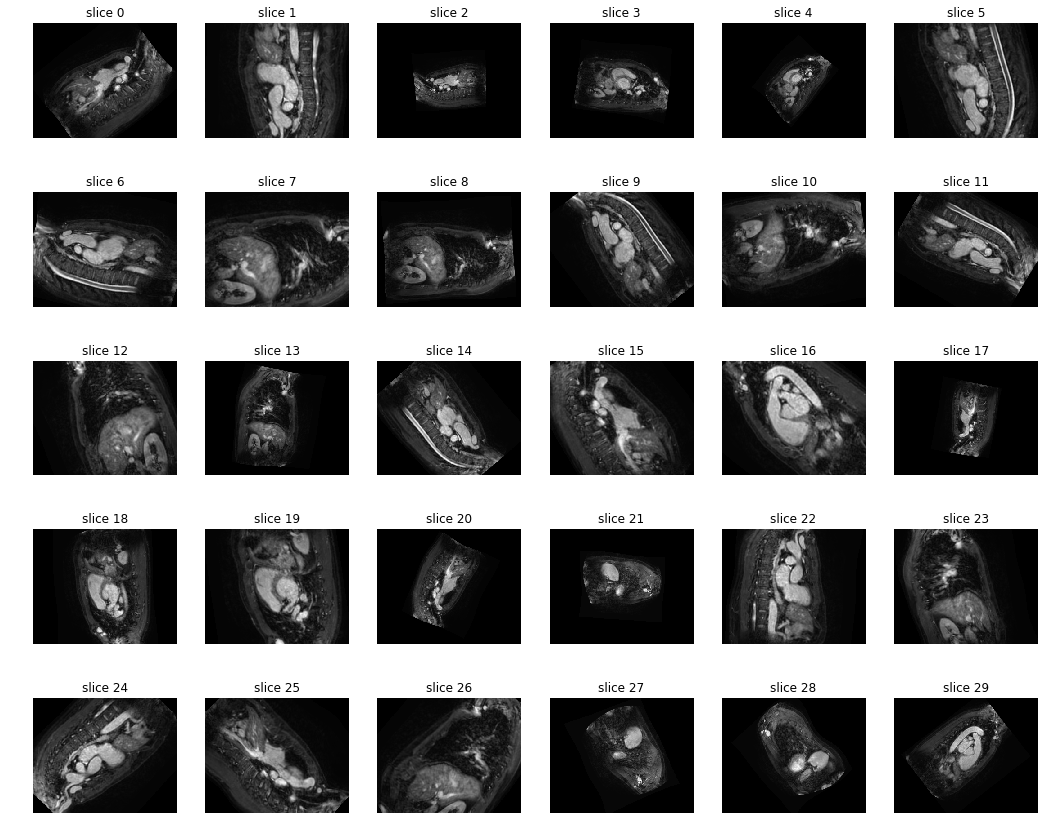

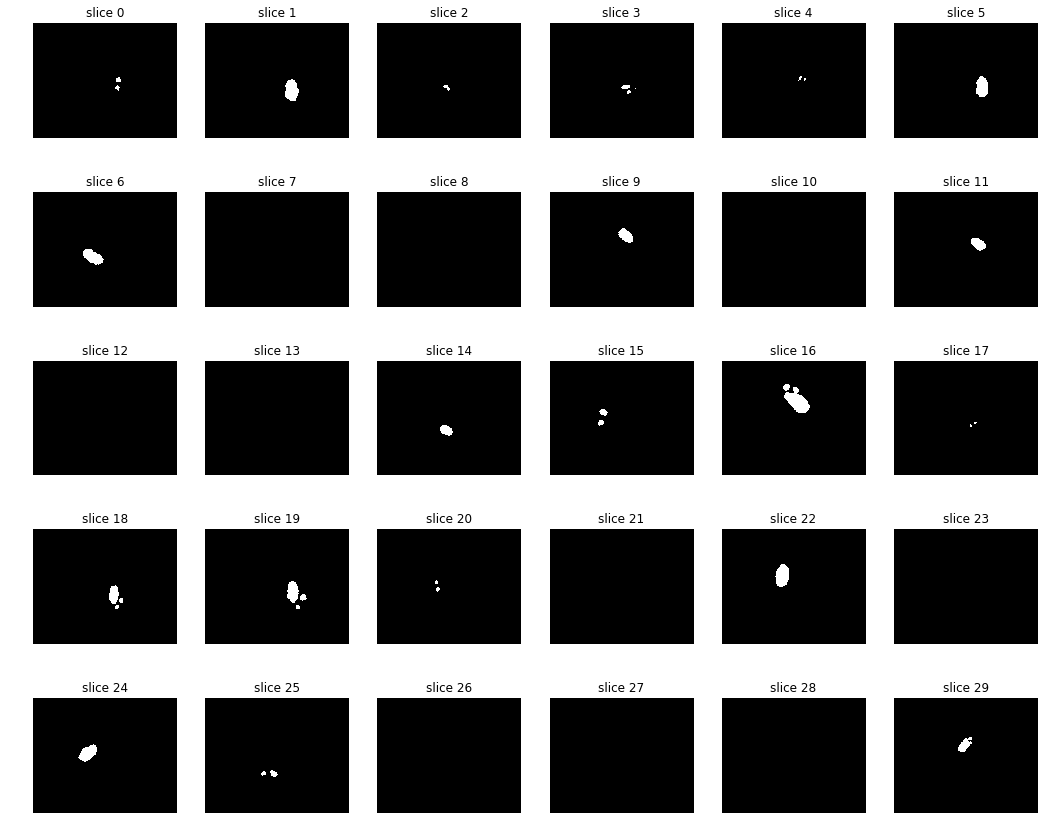

In [33]:
every_ = 1
plotting.plot_scan(x.squeeze(), 0, every_, rows = 5, cols = 6)
plotting.plot_scan(y.squeeze(), 0, every_, rows = 5, cols = 6)